In [1]:
import mezo
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy
import scipy.sparse as ss
from scipy.sparse import linalg as sl

### Good Resources
- [Notes by László Oroszlány](http://oroszl.web.elte.hu/mezo/OL_lecture_notes-1.pdf)
- [Non Equilibrium Green’s Functions for Dummies](https://arxiv.org/pdf/cond-mat/0210519.pdf)
- [Green’s Functions in Quantum Physics, E.N. Economou (Springer, 2005)]()
- [Theory of Quantum Transport at Nanoscale, Dmitry A. Ryndyk Chapter 3. (Springer, 2016)]()

## Task: BHZ model dirty edge local density
The Hamiltonian is
$$
\hat H_{BHZ} = \begin{bmatrix}
\hat H_{QWZ} & 0 \\
0 & \hat H^{\dagger}_{QWZ}
\end{bmatrix}.
$$
In QWZ, we have
$$
\hat T_{x/y} = \frac{\hat\sigma_z + i\hat\sigma_{x/y}}{2}, \hat U = \Delta\hat\sigma_z
$$
My tasks:
- Calculate the site resolved local density of states for a BHZ wire with a scatterer located at the edge of the sample.
- Take simple potetial scattering i.e. $V\propto I_4$
- Take completely random scatterer.

The on-site Hamiltonian for a single site is
$$
\hat H_0 = 
\begin{bmatrix}
\Delta\sigma_z & 0 \\
0 & \Delta\sigma_z
\end{bmatrix},
$$
the hopping elements are
$$
\hat H_{1,x/y} = 
\begin{bmatrix}
T_{x/y} & 0 \\
0 & T^{\dagger}_{x/y}
\end{bmatrix}
$$


The Hamiltonian for one column of the scattering region is
$$
\hat H_0^{\mathrm{col}} = 
\begin{bmatrix}
\ddots &                        &                         &                        &               & \\
       & \hat H_0               &  \hat H_{1,y}           &                        &               & \\
       & \hat H^{\dagger}_{1,y} &  \hat H_0               & \hat H_{1,y}           &               & \\
       &                        &  \hat H^{\dagger}_{1,y} & \hat H_0               & \hat H_{1,y}  & \\
       &                        &                         & \hat H^{\dagger}_{1,y} & \hat H_0      & \\
       &                        &                         &                        &               & \ddots
\end{bmatrix}
$$

The Hamiltonian for the full scattering region is 
$$
\hat H^{S} = 
\begin{bmatrix}
\ddots &                       &                       &                       &                       &\\
       &\hat H_0^{\mathrm{col}}&\hat H_{1,cc}          &                       &                       &\\
       &\hat H^{\dagger}_{1,cc}&\hat H_0^{\mathrm{col}}&\hat H_{1,cc}          &                       &\\
       &                       &\hat H^{\dagger}_{1,cc}&\hat H_0^{\mathrm{col}}&\hat H_{1,cc}          &\\
       &                       &                       &\hat H^{\dagger}_{1,cc}&\hat H_0^{\mathrm{col}}&\\
       &                       &                       &                       &                       &\ddots
\end{bmatrix},
$$
where $\hat H_{1,cc}$ denotes the column-to-column hopping matrix:
$$
\hat H_{1,cc} =
\begin{bmatrix}
\ddots &            &            &            &            &\\
       &\hat H_{1,x}&            &            &            &\\
       &            &\hat H_{1,x}&            &            &\\
       &            &            &\hat H_{1,x}&            &\\
       &            &            &            &\hat H_{1,x}&\\
       &            &            &            &            &\ddots
\end{bmatrix}
$$

To calculate the surface Green's function for the scattering region only, we have to solve
$$
\hat G^{S} = \left(E\hat I - \hat H^S\right)^{-1}
$$

The inverse of the Green function of the full system, including the leads is

$$
\begin{align*}
\hat G^{-1} = 
\begin{bmatrix}
\mathtt{L.gsL}            & -\hat H_{1,cc}           &               \\
-\hat H_{1,cc}^{\dagger } & \hat H^S                 & -\hat H_{1,cc} \\
                          & -\hat H_{1,cc}^{\dagger} & \mathtt{L.gsR}
\end{bmatrix}
\end{align*}
$$

The density of states is
$$
\mathrm{DOS} = \sum\limits_{\sigma}\frac{1}{\pi}\mathrm{Im}\{G(\mathbf{r}, \mathbf{r}, \sigma, \sigma)\},
$$
where $\sigma$ denotes the internal degrees of freedom.

In [2]:
s0 = np.array([[1., 0.], [0., 1.]])
sx = np.array([[0., 1.], [1., 0.]]) 
sy = np.array([[0., -1.0j],[1.0j, 0.]])
sz = np.array([[1., 0.], [0., -1.]])

In [3]:
Ty = 0.5*(sz+1j*sy)
Tx = 0.5*(sz+1j*sx)

In [4]:
H0 = ss.kron(s0, sz)
H0.toarray()

array([[ 1.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0., -1.]])

In [5]:
H1x = ss.bmat([[Tx, None], 
               [None, Tx.T.conj()]])
H1x.toarray()

array([[ 0.5+0.j ,  0. +0.5j,  0. +0.j ,  0. +0.j ],
       [ 0. +0.5j, -0.5+0.j ,  0. +0.j ,  0. +0.j ],
       [ 0. +0.j ,  0. +0.j ,  0.5+0.j ,  0. -0.5j],
       [ 0. +0.j ,  0. +0.j ,  0. -0.5j, -0.5+0.j ]])

In [6]:
H1y = ss.bmat([[Ty, None], 
               [None, Ty.T.conj()]])
H1y.toarray()

array([[ 0.5+0.j,  0.5+0.j,  0. +0.j,  0. +0.j],
       [-0.5+0.j, -0.5+0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0.5+0.j, -0.5+0.j],
       [ 0. +0.j,  0. +0.j,  0.5+0.j, -0.5+0.j]])

In [8]:
def get_H0_col(nrows, Delta):
    """
    Calculate H_0^{\mathrm{col}}
    """
    H0col = ss.kron(np.eye(nrows), Delta*H0)\
    + ss.kron(np.diag(np.ones(nrows-1), 1), H1y)\
    + ss.kron(np.diag(np.ones(nrows-1), -1), H1y.T.conj())
    return H0col

def get_H1_cc(nrows):
    return ss.kron(np.eye(nrows), H1x)

def get_HS(nrows, ncols, Delta):
    """
    Calculate the Hamiltonian for the scattering region, without dirty edge
    """
    H0col = get_H0_col(nrows, Delta)
    H1cc = get_H1_cc(nrows)
    HS = ss.kron(np.eye(ncols), H0col)\
    + ss.kron(np.diag(np.ones(ncols-1), 1), H1cc)\
    + ss.kron(np.diag(np.ones(ncols-1), -1), H1cc.T.conj())
    return HS

def get_HS_dirty(nrows, ncols, Delta, nrowsdirty):
    pass

def get_HS_dirtier(nrows, ncols, Delta, nrowsdirty):
    pass

# def get_H1L_H1S(nrows):
#     """
#     Calculate H_1^L and H_1^S
#     """
#     return ss.kron(np.eye(nrows), Tx)

# def get_H1LS(nrows, c=1):
#     """
#     Calculate H_1^{LS}
#     c -> coupling constant
#     """
#     return ss.kron(np.eye(nrows), c*Tx)

# def get_H0S(nrows, nrowsdirty, V):
#     """
#     Calculate H_0^S.
#     nrowsdirty -> How many rows should have noise
#     V -> Noise scale
#     """
#     H0 = ss.kron(np.eye(nrows), U*sz) + ss.kron(np.diag(np.ones(nrows-1), 1), Ty) + ss.kron(np.diag(np.ones(nrows-1), -1), Ty.T.conj())
#     R1 = ss.kron(np.eye(nrowsdirty), V*s0)
#     R2 = ss.kron(np.eye(nrows-nrowsdirty), s0)
#     H0 = H0 + ss.bmat([[R2, None], [None, R1]])
#     return H0

# def build_qwz_system(nrows, ncols, nrowsdirty, V, c):
#     # Create scattering region
#     H0S = get_H0S(nrows, nrowsdirty, V)
#     H1S = get_H1L_H1S(nrows)
#     H1LS = get_H1LS(nrows, c)
    
#     # This is the purely scattering region, we need to attach the lead to this
#     HScatter = ss.kron(np.eye(ncols-1), H0S)\
#     + ss.kron(np.diag(np.ones(ncols-2), 1), H1S)\
#     + ss.kron(np.diag(np.ones(ncols-2), -1), H1S.T.conj())
    
#     return H0S, H1S, H1LS, HScatter

# def build_bhz_system(nrows, ncols, nrowsdirty, V, c):
#     H0S, H1S, H1LS, H_QWZ = build_qwz_system(nrows, ncols, nrowsdirty, V, c)
#     return H0S, H1S, H1LS, ss.bmat([[H_QWZ, None], 
#                                     [None, H_QWZ.T.conj()]])

# # TODO: Get the Green function
# def get_gf(nrows, ncols, nrowsdirty, V, c, E, alpha):
#     # Create a system
#     H0L = get_H0L(nrows).toarray()
#     H1L = get_H1L_H1S(nrows).toarray()
    
#     # Create lead
#     L = mezo.lead(H0L, H1L)
#     L.set_ene(E)
    
#     # Create scattering region
#     H0S, H1S, H1LS, H = build_bhz_system(nrows, ncols, nrowsdirty, V, c)
#     Heff = E*ss.eye(m=H.shape[0], n=H.shape[1]) - H
    
#     return L, G, Heff

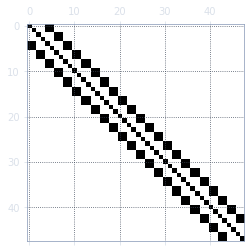

In [9]:
plt.spy( get_H0_col(nrows=12, Delta=2).toarray() )

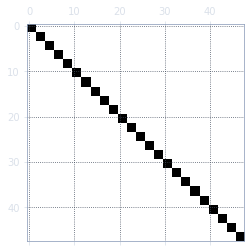

In [10]:
plt.spy( get_H1_cc(nrows=12).toarray() )

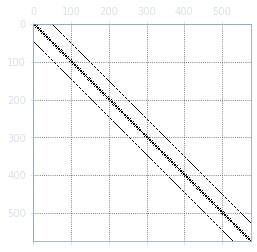

In [17]:
HS = get_HS(12, 12, Delta=2)
plt.spy( HS.toarray() )

In [18]:
E = 1.0
Heff = E*ss.eye(HS.shape[0]) - HS
GS = sl.inv(Heff)

/usr/local/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/usr/local/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [30]:
# Extract the system from G
dof = 4 # we have 4 degrees of freedom on each site
nrows = 12
ncols = 12
len( np.diag(np.imag(GS.toarray())) )

576

In [ ]:
Z=0.1+0.0001j                # energy at which we evaluate the Green's function

In [ ]:
H0S, H1S, H1LS, H_BHZ = build_bhz_system(nrows=5, ncols=5, nrowsdirty=2, V=4.0, c=1)

In [ ]:
plt.spy(H1S)

In [ ]:
plt.spy(H0S)

In [ ]:
plt.spy(H_BHZ)

In [ ]:
ss.eye(m=H_BHZ.shape[0], n=H_BHZ.shape[1])

In [ ]:
L, G, Heff = get_gf(nrows=10, ncols=10, nrowsdirty = 5, V=6, c=1, E=-1, alpha=1)

In [ ]:
plt.spy(Heff)

In [ ]:
plt.spy(sl.inv(Heff))

In [ ]:
DOS = -1.j*(G - G.T.conj())
np.max(np.abs(DOS))

In [ ]:
plt.matshow(np.abs(L.gsL))

In [ ]:
plt.matshow(np.abs(G))

# Sandbox area

In [ ]:
nA = 3
nB = 2
A = ss.kron(np.eye(nA), 7*sz)
B = ss.kron(np.eye(nB), 2*sz)

In [ ]:
H = ss.bmat([[A, None], [None, B]]).toarray()
H

In [ ]:
LS = np.zeros(shape=(nA+nB, nA+nB))
LS[nA-1,nA]=1
LS[nA,nA-1]=1
LS = ss.kron(LS, 6*sx)
LS.toarray()

In [ ]:
(H+LS)

In [ ]:
plt.spy(H+LS)

In [ ]:
V = 6
nrowsdirty = 2
nrows=5
R1 = ss.kron(np.eye(nrowsdirty), V*s0)
R2 = ss.kron(np.eye(nrows-nrowsdirty), s0)
ss.bmat([[R2, None], [None, R1]]).toarray()

In [ ]:
A = B = 2

In [ ]:
def getA():
    A = 3\
    + 3\
    + 2
    return A

In [ ]:
getA()